In [1]:
# this file takes in all files and produce the appropriate s2d analysis
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
dspl_html = lambda x: display_html(x, raw=True)
rouge = load('rouge')

In [4]:
root_path = Path("/home/vente/repos/nlgs-research")


INPUT_TO_ANALYSE = ""

# TODO: get this file form argv so driver code can run all analyses in a loop
# or just analayse the outputs of the best model...?
pkl = max( (root_path / "pipeline/predictions").glob("*s2d*"))
pkl.name

's2d-t5-small-5.pkl'

In [5]:
OUTPUT_PATH = Path("/home/vente/repos/nlgs-research/pipeline/scores") / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/s2d-t5-small-5')

In [6]:
test_predictions = pd.read_pickle(pkl)

In [7]:
root_path = Path("/home/vente/repos/nlgs-research")


INPUT_TO_ANALYSE = ""

# TODO: get this file form argv so driver code can run all analyses in a loop
# or just analayse the outputs of the best model...?
pkl = list( (root_path / "pipeline/predictions").glob("*s2d*"))[1]
pkl.name

's2d-t5-base-5.pkl'

In [8]:
OUTPUT_PATH = Path("/home/vente/repos/nlgs-research/pipeline/scores") / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/s2d-t5-base-5')

In [9]:
test_predictions = pd.read_pickle(pkl)

 How do we formulate F-measure for this task? Usually there is a fixed number
 of classes, and one label per class. But this class is fundimentally about
 extracting many labels from a single sequence.
 Approach: treat one data sample as multiple classification events, compute the
 f-measure across each label in an needs to be order-insensitive by comparing
 the sets themselves

 ```
 TP <- PRED `intersect` GT |> length
 FP <- GT - PRED |> length
 FN <- PRED - GT |> length
 F1 <- harmonic_mean(prec, recl)
 prec <- TP / (TP + FP)
 recl <- TP / (TP + FN)
 ```

In [10]:
# define set notion of precision when multiple labels are assigned
# to a single instance, with epsilon preventing div by zero
def compute_f_measure(pred: set[str], gt: set[str], epsilon=1e-99):
    tp = len(pred.intersection(gt)) # pred true and actually true
    fp = len(gt - pred)             # in pred but not in gt
    fn = len(pred - gt)             # not in pred but actualy true

    prec = tp / (tp + fp + epsilon) 
    recl = tp / (tp + fn + epsilon) 
    f1 = (2 * prec * recl) / (prec + recl + epsilon)
    return f1

 ## Unit Tests

In [11]:
assert compute_f_measure(set("a"), set('a')) == 1
assert compute_f_measure(set("ab"), set('a')) == 2/3
assert compute_f_measure(set() , set('a')) == 0

In [12]:
# don't penalize for quotes or spaces
norm_split_set = lambda x: x.str.upper().str.replace("'", '').str.replace(' ','').map(_.split(";")).map(set)
y_pred = norm_split_set(test_predictions['decoded'])
y_pred

38668    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38669    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38670    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38671    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38672    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
                               ...                        
42887    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42888    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
42889    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
42890    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
42891    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
Name: decoded, Length: 4224, dtype: object

In [13]:
y_true = norm_split_set(test_predictions['sd'])
y_true

38668    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38669    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38670    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38671    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38672    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
                               ...                        
42887    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42888    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
42889    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
42890    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
42891    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
Name: sd, Length: 4224, dtype: object

In [14]:
f1_scores = seq(y_pred).zip(y_true).starmap(compute_f_measure).to_list()
f1_scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 

In [15]:
def compute_closest_edit_dists(y_pred, y_true):
    # we need an alignment of the labels by edit distance
    return (
      seq(y_pred)
        .cartesian(y_true)
        .starmap(edit_distance) 
        .sorted()
        # full penalty for missed guesses or too many guesses
        # .take(seq(y_true, y_pred).map(len).max())
        .to_list()
    )

edit_distances = (
  seq(y_pred)
    .zip(y_true)
    .starmap(compute_closest_edit_dists)
    .map(np.mean)
    .to_list()
)
edit_distances 

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 7.0,
 0.0,
 0.0,
 10.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 21.5,
 17.5,
 17.5,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [16]:
results = test_predictions
results['f1_scores'] = f1_scores
results['med_scores'] = edit_distances # med mean edit distance
results 

,record_idx,seed_number,subset,category,split_index,sd,nl,task,input_ids,attention_mask,labels,pred_ids,decoded,f1_scores,med_scores
38668,14495,0,test,Airport,0,"Abilene Regional Airport|city served|Abilene, ...","Abilene, Texas is served by the Abilene region...",s2d,"[891, 23, 14205, 6, 2514, 19, 2098, 57, 8, 891...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[891, 23, 14205, 7676, 5735, 9175, 6726, 2098,...","[0, 891, 23, 14205, 7676, 5735, 9175, 6726, 20...","Abilene Regional Airport|city served|Abilene, ...",1.000000,0.000000
38669,14495,1,test,Airport,0,"Abilene Regional Airport|city served|Abilene, ...",Abilene Regional Airport serves the city of Ab...,s2d,"[891, 23, 14205, 7676, 5735, 4657, 8, 690, 13,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[891, 23, 14205, 7676, 5735, 9175, 6726, 2098,...","[0, 891, 23, 14205, 7676, 5735, 9175, 6726, 20...","Abilene Regional Airport|city served|Abilene, ...",1.000000,0.000000
38670,14496,0,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas Airport can be fo...,s2d,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,1.000000,0.000000
38671,14496,1,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas airport is locate...,s2d,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,1.000000,0.000000
38672,14496,2,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas Airport is locate...,s2d,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42887,16092,1,test,University,1597,School of Business and Social Sciences at the ...,"Established in 1928, the School of Business an...",s2d,"[25275, 16, 29004, 6, 8, 1121, 13, 1769, 11, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,1.000000,28.612245
42888,16093,0,test,University,1598,School of Business and Social Sciences at the ...,Denmark is led by the Monarchy of Demark and t...,s2d,"[18001, 19, 2237, 57, 8, 2963, 7064, 63, 13, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 18001, 9175, 22900, 564, 9175, 434, 291, 7...",Denmark|leader name|Lars Lokke Rasmussen; Scho...,0.833333,39.314286
42889,16093,1,test,University,1598,School of Business and Social Sciences at the ...,The School of Business and Social Sciences at ...,s2d,"[37, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 18001, 9175, 22900, 564, 9175, 434, 291, 7...",Denmark|leader name|Lars Lokke Rasmussen; Scho...,0.923077,41.309524
42890,16093,2,test,University,1598,School of Business and Social Sciences at the ...,The School of Business and Social Sciences at ...,s2d,"[37, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 18001, 9175, 22900, 564, 9175, 434, 291, 7...",Denmark|leader name|Lars Lokke Rasmussen; Scho...,0.923077,41.642857


In [17]:
# let's define nth finish and "place-number" as 0 for "finishing in first place"
# give find the place-number given a score: ties should have the same place
score_to_nth_finish: dict[float, int]= (
  seq(f1_scores)
    .sorted(reverse=True) # Highest to lowest
    .zip_with_index()     # gives an over-estimate of nth-finish
    .group_by(get[0])     # so we group by the f1 scores
    .map(get[1])          # then we get the actual place of the score
    .map(get[0])          # it's sorted, so take the first to account for ties
    .to_dict()            # convert to dictionary
)
seq(score_to_nth_finish.items()).to_pandas()

,0,1
0,1.000000,0
1,0.923077,3369
2,0.909091,3386
3,0.888889,3397
4,0.857143,3458
5,0.833333,3535
6,0.833333,3545
7,0.800000,3546
8,0.800000,3642
9,0.769231,3694


  so we can sort by this key later, and also get a broad impression
 of the distribution of errors. Later we'll plot a histogram anyway.

 ## Error analysis

In [18]:
results['nth_finish'] = results['f1_scores'].map(score_to_nth_finish)
results['nth_finish'] 

38668       0
38669       0
38670       0
38671       0
38672       0
         ... 
42887       0
42888    3545
42889    3369
42890    3369
42891       0
Name: nth_finish, Length: 4224, dtype: int64

In [19]:
results[['nth_finish','med_scores', 'f1_scores', 'decoded','sd']].round(3).to_csv('vis.csv')

In [20]:
# 
worst_finishes = results[results.f1_scores == 0]
dspl_html(worst_finishes[['med_scores','f1_scores', 'decoded','sd']].to_html())
print(len(worst_finishes))

,med_scores,f1_scores,decoded,sd
38700,6.000000,0.0,Andrews Airport|elevation above the sea level (in metres)|973.0,Andrews County Airport|elevation above the sea level (in metres)|973.0
38750,7.000000,0.0,"Maple Ridge Township, Alpena County, Michigan|country|United States","Maple Ridge Township, Alpena County, Michigan|is part of|United States"
38751,7.000000,0.0,"Maple Ridge Township, Alpena County, Michigan|country|United States","Maple Ridge Township, Alpena County, Michigan|is part of|United States"
38754,10.000000,0.0,Port Authority of New Jersey|region served|New Jersey,Port Authority of New York and New Jersey|region served|New Jersey
38803,21.500000,0.0,"Alison ODonnell|genre|Singing; Alison ODonnell|instrument|Bodhran, percussion, autoharp","Alison ODonnell|instrument|Voice, bodhran, percussion, autoharp"
38805,17.500000,0.0,"Alison ODonnell|instrument|Singing; Alison ODonnell|instrument|Bodhran, percussion, autoharp","Alison ODonnell|instrument|Voice, bodhran, percussion, autoharp"
38806,2.000000,0.0,Allen Forrest|birth date|1981-02-4),Allen Forrest|birth date|1981-02-04
38807,1.000000,0.0,Allen Forrest|birth date|1981-04-04,Allen Forrest|birth date|1981-02-04
38837,4.000000,0.0,Manchester|is part of|Greater Manchester Area,Manchester|is part of|Greater Manchester
38840,10.000000,0.0,Polydor|record label|Polydor; Polydor|location|London,Polydor Records|location|London


79


In [21]:
results[['med_scores','f1_scores']].describe()

,med_scores,f1_scores
count,4224.000000,4224.000000
mean,15.489052,0.928242
std,10.574804,0.181784
min,0.000000,0.000000
25%,9.000000,1.000000
50%,16.527778,1.000000
75%,22.000000,1.000000
max,77.000000,1.000000


<Axes: >

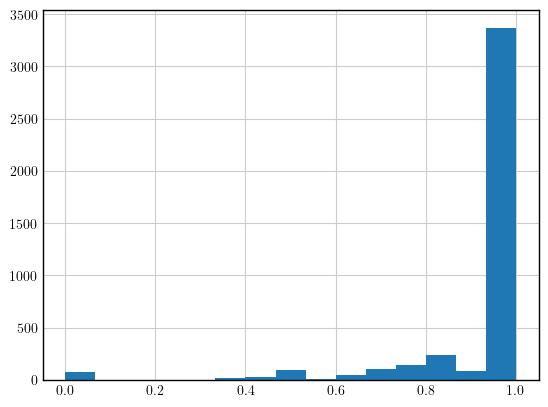

In [22]:
results.f1_scores.hist(bins=15)

<Axes: >

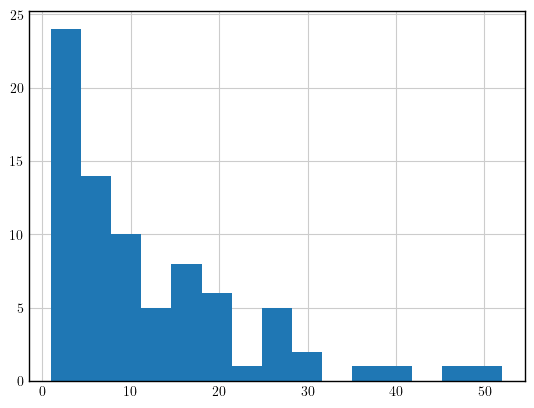

In [23]:
worst_finishes.med_scores.hist(bins=15)

In [24]:
# sparse-bar formation of the same histogram data
ax = (
  worst_finishes
    .med_scores
    .sort_values()
    .map(lambda x: (x // 10) * 10)
    .map(lambda x: "[" + str(int(x)) + ", " + str(int(x+10)) + ")")
    .value_counts()
  # .plot.bar()
)
# ax.set_yscale('log')
print(ax.to_latex())
print(ax.to_markdown())

\begin{tabular}{lr}
\toprule
{} &  med\_scores \\
\midrule
[0, 10)  &          44 \\
[10, 20) &          19 \\
[20, 30) &          11 \\
[30, 40) &           3 \\
[40, 50) &           1 \\
[50, 60) &           1 \\
\bottomrule
\end{tabular}

|          |   med_scores |
|:---------|-------------:|
| [0, 10)  |           44 |
| [10, 20) |           19 |
| [20, 30) |           11 |
| [30, 40) |            3 |
| [40, 50) |            1 |
| [50, 60) |            1 |


<ipython-input-24-0a6ffe0c3c54>:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ax.to_latex())


<Axes: >

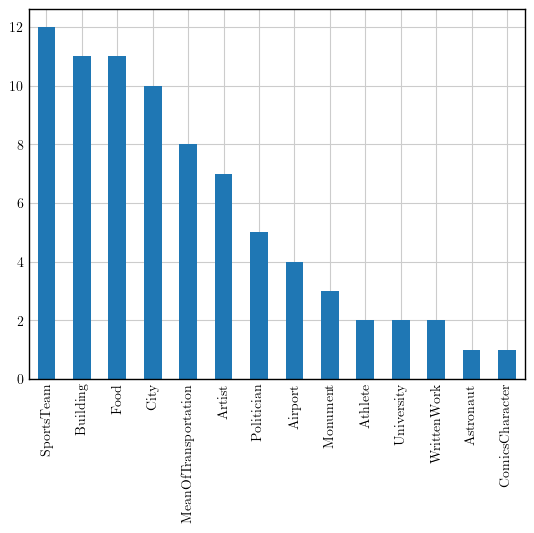

In [25]:
worst_finishes.category.value_counts().plot.bar()

<Axes: >

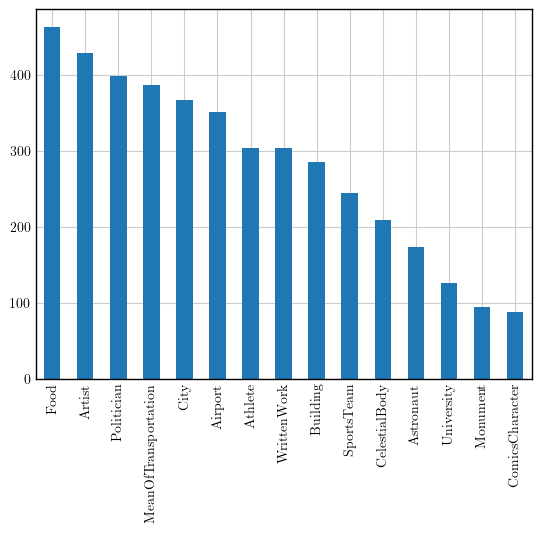

In [26]:
train_corpus = test_predictions
train_corpus.category.value_counts().plot.bar()

<Axes: >

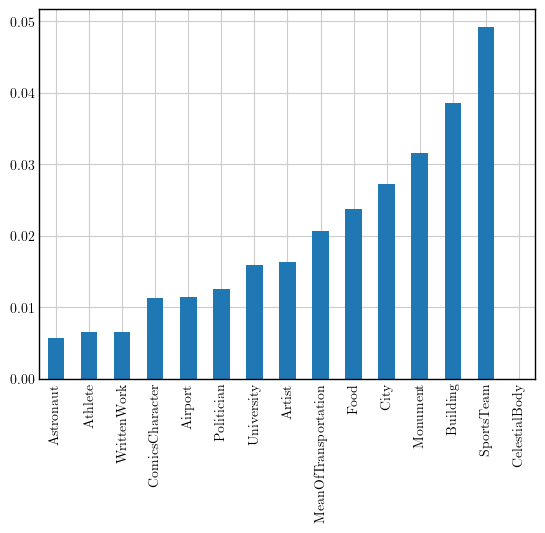

In [27]:
# normalized performance by category
npc = worst_finishes.category.value_counts() / train_corpus.category.value_counts()
npc.sort_values().plot.bar()

 the network performs poorly on buildings, sports teams, and monuments when
 normalized for class prevalence. Poor performance on monument may be explained
 by its under-representation in the training set. This does not hold for sports
 teams and monuments, which have good representation in the training set but do
 not have good performance. This points to qualitative features particular to
 entries in those categories.

In [28]:
worst_finishes.sort_values(by=['med_scores'])

,record_idx,seed_number,subset,category,split_index,sd,nl,task,input_ids,attention_mask,labels,pred_ids,decoded,f1_scores,med_scores,nth_finish
38807,14551,1,test,Artist,56,Allen Forrest|birth date|1981-02-04,Allen Forrest's birth date is 04th February 1981.,s2d,"[10618, 242, 6216, 31, 7, 3879, 833, 19, 11484...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[10618, 242, 6216, 9175, 20663, 833, 9175, 241...","[0, 10618, 242, 6216, 9175, 20663, 833, 9175, ...",Allen Forrest|birth date|1981-04-04,0.0,1.0,4145
39269,14742,4,test,MeanOfTransportation,247,AIDAstella|maiden voyage|2013-03-17,The ship AIDAstella had her maiden voyage on M...,s2d,"[37, 4383, 71, 26483, 7, 6714, 9, 141, 160, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[71, 26483, 7, 6714, 9, 9175, 6840, 537, 6232,...","[0, 71, 26483, 7, 6714, 9, 9175, 6840, 537, 62...",AIDAstella|maiden voyage|2003-03-17,0.0,1.0,4145
38980,14619,0,test,Building,124,Adare Manor|architect|James Pain and George Ri...,The architects James Pain and George Richard P...,s2d,"[37, 19186, 2549, 19043, 11, 3080, 4117, 19043...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 355, 1140, 127, 9175, 7064, 23, 5822, 1...","[0, 1980, 355, 1140, 127, 9175, 7064, 23, 5822...",Adare Manor|architect|James Pain and George Ri...,0.0,1.0,4145
38981,14619,1,test,Building,124,Adare Manor|architect|James Pain and George Ri...,James Pain and George Richard Pain are the arc...,s2d,"[2549, 19043, 11, 3080, 4117, 19043, 33, 8, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 355, 1140, 127, 9175, 7064, 23, 5822, 1...","[0, 1980, 355, 1140, 127, 9175, 7064, 23, 5822...",Adare Manor|architect|James Pain and George Ri...,0.0,1.0,4145
38982,14619,2,test,Building,124,Adare Manor|architect|James Pain and George Ri...,James Pain and George Richard Pain were the Ad...,s2d,"[2549, 19043, 11, 3080, 4117, 19043, 130, 8, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 355, 1140, 127, 9175, 7064, 23, 5822, 1...","[0, 1980, 355, 1140, 127, 9175, 7064, 23, 5822...",Adare Manor|architect|James Pain and George Ri...,0.0,1.0,4145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39597,14882,1,test,WrittenWork,387,Weymouth Sands|preceded by|A Glastonbury Romance,A Glastonbury Romance was published before Wey...,s2d,"[71, 10941, 4411, 7165, 3385, 565, 47, 1790, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 63, 11975, 5440, 7, 9175, 2026, 565, 221...","[0, 71, 10941, 4411, 7165, 3385, 565, 9175, 20...",A Glastonbury Romance|preceded by|Weymouth Sands,0.0,30.0,4145
39491,14841,1,test,SportsTeam,346,Luciano Spalletti|club|Udinese Calcio,Luciano Spalletti has been associated with Udi...,s2d,"[11977, 152, 32, 5641, 195, 10652, 65, 118, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11977, 152, 32, 5641, 195, 10652, 9175, 13442...","[0, 11977, 152, 32, 5641, 195, 10652, 9175, 30...",Luciano Spalletti|associated band/associated m...,0.0,36.0,4145
42463,15930,2,test,City,1435,"Anderson, Indiana|is part of|Fall Creek Townsh...","Located in the United States, in Madison Count...",s2d,"[3, 8691, 16, 8, 907, 1323, 6, 16, 16168, 1334...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11825, 6, 11494, 9175, 159, 294, 13, 9175, 37...","[0, 11825, 6, 10212, 9175, 159, 294, 13, 9175,...","Anderson, Wisconsin|is part of|Fall Creek Town...",0.0,38.8,4145
39012,14635,0,test,Building,140,Julia Morgan|significant building|Los Angeles ...,Julia Morgan has designed many significant bui...,s2d,"[18618, 11147, 65, 876, 186, 1516, 3950, 6, 37...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[18618, 11147, 9175, 26251, 740, 9175, 434, 32...","[0, 3144, 4975, 27279, 18, 5420, 8721, 52, 917...",Los Angeles Herald-Examiner|architect|Julia Mo...,0.0,47.0,4145
